In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# Personal Color 분류 CLIP - zeroshot

# 라이브러리 임포트
!pip install git+https://github.com/openai/CLIP.git
!pip install ftfy regex tqdm

import torch
import clip
from PIL import Image
import os
from torchvision import transforms
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from google.colab import files
import glob

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-x7dnj84d
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-x7dnj84d
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [19]:
# 이미지 전처리 함수
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = preprocess(image)
    return image

In [20]:
# 모델 선택 - ViT-B/32
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# class label
class_names = [
    'A portrait photo of a person with warm spring skin tone',
    'A portrait photo of a person with cool summer skin tone',
    'A portrait photo of a person with warm autumn skin tone',
    'A portrait photo of a person with cool winter skin tone']

# dataset 경로 지정
dataset_dir = '/content/drive/Othercomputers/내 노트북/personal-color-data/'

# dataset 타입 (train, test)
dataset_types = ['train', 'test']

# 이미지 경로와 라벨을 저장할 dict
image_paths = {'train': [], 'test': []}
labels = {'train': [], 'test': []}

# 클래스 이름과 해당 폴더 이름 mapping
class_folders = ['spring', 'summer', 'fall', 'winter']

for dataset_type in dataset_types:
    for idx, class_folder in enumerate(class_folders):
        class_dir = os.path.join(dataset_dir, dataset_type, class_folder)
        for img_path in glob.glob(os.path.join(class_dir, '*.*')):
            if img_path.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths[dataset_type].append(img_path)
                labels[dataset_type].append(idx)


# label tokenize
text_inputs = clip.tokenize(class_names).to(device)

In [21]:
from torch.utils.data import Dataset, DataLoader

class ImageDataset(Dataset):
    def __init__(self, image_paths, labels):
        self.image_paths = image_paths
        self.labels = labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = preprocess_image(self.image_paths[idx])
        label = self.labels[idx]
        return image, label

# 결과 저장을 위한 dict
all_preds = {'train': [], 'test': []}
all_labels = {'train': [], 'test': []}

for dataset_type in dataset_types:
    print(f"\n{dataset_type.upper()} 데이터셋 예측 시작:")
    dataset = ImageDataset(image_paths[dataset_type], labels[dataset_type])
    dataloader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)

    model.eval()
    model = model.to(device)

    # text feature 추출
    with torch.no_grad():
        text_features = model.encode_text(text_inputs).to(device)
        text_features /= text_features.norm(dim=-1, keepdim=True)

    with torch.no_grad():
        for images, labels_batch in tqdm(dataloader):
            images = images.to(device)
            labels_batch = labels_batch.to(device)

            # image feature 추출
            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)

            # 유사도 계산
            logits_per_image = image_features @ text_features.t()
            probs = logits_per_image.softmax(dim=-1)

            # 예측
            preds = probs.argmax(dim=-1)

            # 결과 저장
            all_preds[dataset_type].extend(preds.cpu().numpy())
            all_labels[dataset_type].extend(labels_batch.cpu().numpy())



TRAIN 데이터셋 예측 시작:


100%|██████████| 81/81 [00:40<00:00,  2.01it/s]



TEST 데이터셋 예측 시작:


100%|██████████| 15/15 [00:06<00:00,  2.19it/s]



TRAIN acc:
train zero-shot acc: 29.47%

분류 결과:
              precision    recall  f1-score   support

      spring       0.27      0.59      0.37      1312
      summer       0.35      0.19      0.25      1168
        fall       0.31      0.28      0.29      1338
      winter       0.34      0.11      0.16      1309

    accuracy                           0.29      5127
   macro avg       0.32      0.29      0.27      5127
weighted avg       0.32      0.29      0.27      5127



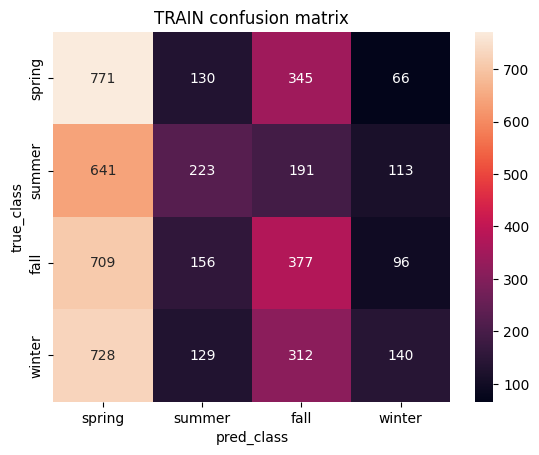


TEST acc:
test zero-shot acc: 27.85%

분류 결과:
              precision    recall  f1-score   support

      spring       0.24      0.59      0.34       214
      summer       0.29      0.21      0.24       189
        fall       0.34      0.23      0.27       266
      winter       0.38      0.12      0.19       268

    accuracy                           0.28       937
   macro avg       0.31      0.29      0.26       937
weighted avg       0.32      0.28      0.26       937



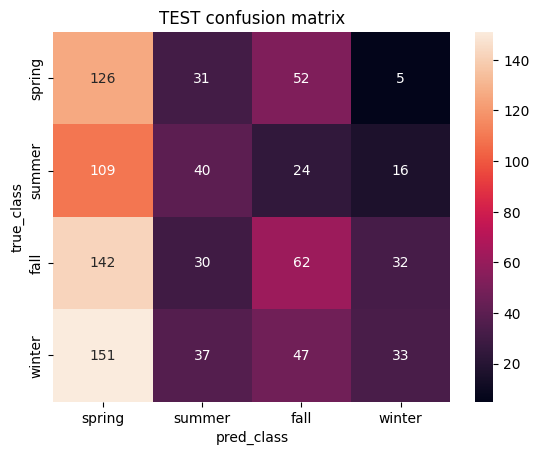

In [22]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

for dataset_type in dataset_types:
    print(f"\n{dataset_type.upper()} acc:")
    preds = all_preds[dataset_type]
    labels_true = all_labels[dataset_type]

    # 정확도
    accuracy = accuracy_score(labels_true, preds)
    print(f'{dataset_type} zero-shot acc: {accuracy * 100:.2f}%')

    # 결과 출력
    print('\n분류 결과:')
    print(classification_report(labels_true, preds, target_names=['spring', 'summer', 'fall', 'winter']))

    # 혼동 행렬 시각화
    cm = confusion_matrix(labels_true, preds)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=['spring', 'summer', 'fall', 'winter'], yticklabels=['spring', 'summer', 'fall', 'winter'])
    plt.title(f'{dataset_type.upper()} confusion matrix')
    plt.xlabel('pred_class')
    plt.ylabel('true_class')
    plt.show()
